In [2]:
import numpy as np
from sklearn.datasets import make_sparse_coded_signal
from sklearn.decomposition import DictionaryLearning

import matplotlib.pyplot as plt

import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
#from scipy.stats import pearsonr as corr
from tqdm import tqdm
import yaml
from munkres import Munkres
import json

import sys
sys.path.append('../')

from experiments import generate_data
from models import SparseCoding, SparseAutoEncoder, GatedSAE, TopKSAE
from flop_counter import calculate_inference_flops, calculate_training_flops
from metrics import mcc, corr

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
def pairwise_corr(z, z_):
    return np.mean([corr(a, b)[0] for a, b in zip(z.T, z_.T)])

In [4]:
# Parameters
N = 16  # number of sparse sources (true dimension)
K = 3  # number of active components
M = 8  # number of measurements
seed = 20240625
num_data = 1024
num_step = 20000
batch_size = 32

# SKLEARN

In [5]:
X, dictionary, code = make_sparse_coded_signal(
    n_samples=30, n_components=15, n_features=20, n_nonzero_coefs=10,
    random_state=42,
)

In [6]:
X.shape, dictionary.shape, code.shape

((30, 20), (15, 20), (30, 15))

In [7]:
dict_learner = DictionaryLearning(
    n_components=15, transform_algorithm='lasso_lars', transform_alpha=0.1,
    random_state=42,
)
X_transformed = dict_learner.fit(X).transform(X)

# Ours

In [8]:
S, X, D = generate_data(N, M, K, num_data * 2, seed=seed)
S_train = S[:num_data].to(device)
X_train = X[:num_data].to(device)
S_test = S[num_data:].to(device)
X_test = X[num_data:].to(device)
D_train = D.to(device)

S_train.shape, S_test.shape, X.shape, D.shape

(torch.Size([1024, 16]),
 torch.Size([1024, 16]),
 torch.Size([2048, 8]),
 torch.Size([16, 8]))

In [9]:
def mse(z, z_):
    return torch.mean((z - z_) ** 2)

def cossim(z, z_):
    return - F.cosine_similarity(z.T, z_.T).mean()

def train(model, lr=1e-3, num_step=10000, log_step=10, verbose=1, objective='mse', wd=0):
    if objective == 'mse':
        criterion = mse
    elif objective == 'cossim':
        criterion = cossim
    optim = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    log = {'step': [], 'mcc_train': [], 'loss_train': [], 'mcc_test': [], 'loss_test': []}
    s_train = S_train.detach().cpu().numpy()
    s_test = S_test.detach().cpu().numpy()
    for i in tqdm(range(num_step)):
        S_ = model(X_train)
        loss = criterion(S_train, S_)
        optim.zero_grad()
        loss.backward()
        optim.step()
        if i > 0 and not i % log_step:
            log['step'].append(i)
            log['loss_train'].append(loss.item())
            log['mcc_train'].append(pairwise_corr(s_train, S_.detach().cpu().numpy()))
            with torch.no_grad():
                S_ = model(X_test)
                loss = criterion(S_test, S_)
            log['loss_test'].append(loss.item())
            log['mcc_test'].append(pairwise_corr(s_test, S_.detach().cpu().numpy()))
            if not i % 1000 and verbose > 1:
                print([(k, log[k][-1]) for k in log])
    if verbose > 0:
        print([(k, log[k][-1]) for k in log])
    return log

def plot(log):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(np.array(log['step']) + 1, log['mcc_train'], '-', label='train')
    plt.plot(np.array(log['step']) + 1, log['mcc_test'], '-', label='test')
    plt.grid()
    plt.semilogx()
    plt.legend()
    plt.xlabel('train step')
    plt.ylabel('MCC')

    plt.subplot(1, 2, 2)
    plt.plot(np.array(log['step']) + 1, log['loss_train'], '-', label='train')
    plt.plot(np.array(log['step']) + 1, log['loss_test'], '-', label='test')
    plt.grid()
    plt.semilogx()
    plt.legend()
    plt.xlabel('train step')
    plt.ylabel('Loss')

    plt.tight_layout()
    plt.show()

100%|██████████| 10000/10000 [00:12<00:00, 825.69it/s]


[('step', 9990), ('mcc_train', np.float64(0.4876503538747364)), ('loss_train', 0.10928411036729813), ('mcc_test', np.float64(0.4743806522531897)), ('loss_test', 0.11294011026620865)]
mse


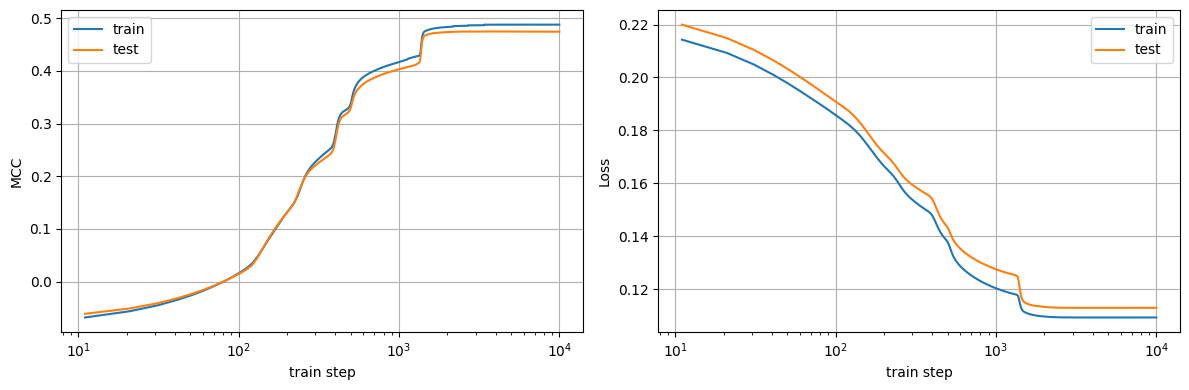

100%|██████████| 10000/10000 [00:14<00:00, 699.88it/s]


[('step', 9990), ('mcc_train', np.float64(0.8191199671601469)), ('loss_train', -0.8371736407279968), ('mcc_test', np.float64(0.8125634025166283)), ('loss_test', -0.8314725160598755)]
cossim


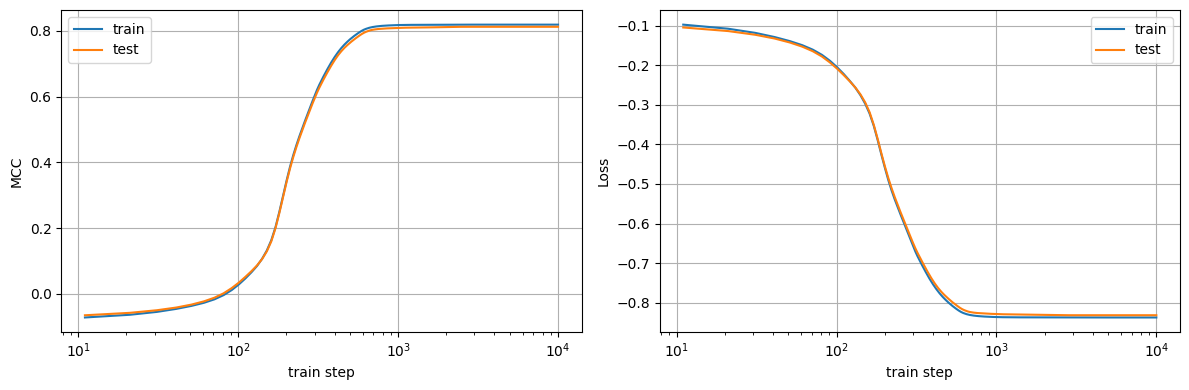

In [10]:
for obj in ['mse', 'cossim']:
    torch.manual_seed(seed)
    SAE = nn.Sequential(nn.Linear(M, N), nn.ReLU()).to(device)
    log = train(model=SAE, verbose=1, objective=obj)
    print(obj)
    plot(log)

In [12]:
num_rep = 5
logs = {'mse': [], 'cossim': []}
for rep in range(num_rep):
    for obj in ['mse', 'cossim']:
        print(rep, obj)
        torch.manual_seed(seed + rep)
        SAE = nn.Sequential(nn.Linear(M, N), nn.ReLU()).to(device)
        logs[obj].append(train(model=SAE, verbose=1, objective=obj))

0 mse


100%|██████████| 10000/10000 [00:12<00:00, 828.97it/s]


[('step', 9990), ('mcc_train', np.float64(0.4876503538747364)), ('loss_train', 0.10928411036729813), ('mcc_test', np.float64(0.4743806522531897)), ('loss_test', 0.11294011026620865)]
0 cossim


100%|██████████| 10000/10000 [00:14<00:00, 692.26it/s]


[('step', 9990), ('mcc_train', np.float64(0.8191199671601469)), ('loss_train', -0.8371736407279968), ('mcc_test', np.float64(0.8125634025166283)), ('loss_test', -0.8314725160598755)]
1 mse


100%|██████████| 10000/10000 [00:13<00:00, 762.14it/s]


[('step', 9990), ('mcc_train', np.float64(0.7667765372702116)), ('loss_train', 0.05659899860620499), ('mcc_test', np.float64(0.7574454318698107)), ('loss_test', 0.06262706220149994)]
1 cossim


100%|██████████| 10000/10000 [00:14<00:00, 683.47it/s]


[('step', 9990), ('mcc_train', np.float64(0.8830167205075226)), ('loss_train', -0.897272527217865), ('mcc_test', np.float64(0.8748519701861138)), ('loss_test', -0.889917254447937)]
2 mse


100%|██████████| 10000/10000 [00:13<00:00, 741.77it/s]


[('step', 9990), ('mcc_train', np.float64(0.8827312224065087)), ('loss_train', 0.037582576274871826), ('mcc_test', np.float64(0.8751213257048609)), ('loss_test', 0.04079893231391907)]
2 cossim


100%|██████████| 10000/10000 [00:14<00:00, 688.43it/s]


[('step', 9990), ('mcc_train', np.float64(0.8828598589589525)), ('loss_train', -0.8971363306045532), ('mcc_test', np.float64(0.8748625364460842)), ('loss_test', -0.8899537920951843)]
3 mse


100%|██████████| 10000/10000 [00:13<00:00, 733.05it/s]


[('step', 9990), ('mcc_train', np.float64(0.8827616298417782)), ('loss_train', 0.0375768281519413), ('mcc_test', np.float64(0.8749105009159059)), ('loss_test', 0.040878184139728546)]
3 cossim


100%|██████████| 10000/10000 [00:14<00:00, 705.45it/s]


[('step', 9990), ('mcc_train', np.float64(0.8828576683658982)), ('loss_train', -0.8971328139305115), ('mcc_test', np.float64(0.8750115757802805)), ('loss_test', -0.8900867700576782)]
4 mse


100%|██████████| 10000/10000 [00:13<00:00, 764.40it/s]


[('step', 9990), ('mcc_train', np.float64(0.8231187560089506)), ('loss_train', 0.04696998372673988), ('mcc_test', np.float64(0.8146083545575096)), ('loss_test', 0.047919075936079025)]
4 cossim


100%|██████████| 10000/10000 [00:14<00:00, 702.05it/s]

[('step', 9990), ('mcc_train', np.float64(0.8334991973844117)), ('loss_train', -0.8472437262535095), ('mcc_test', np.float64(0.8234541191884209)), ('loss_test', -0.8372785449028015)]


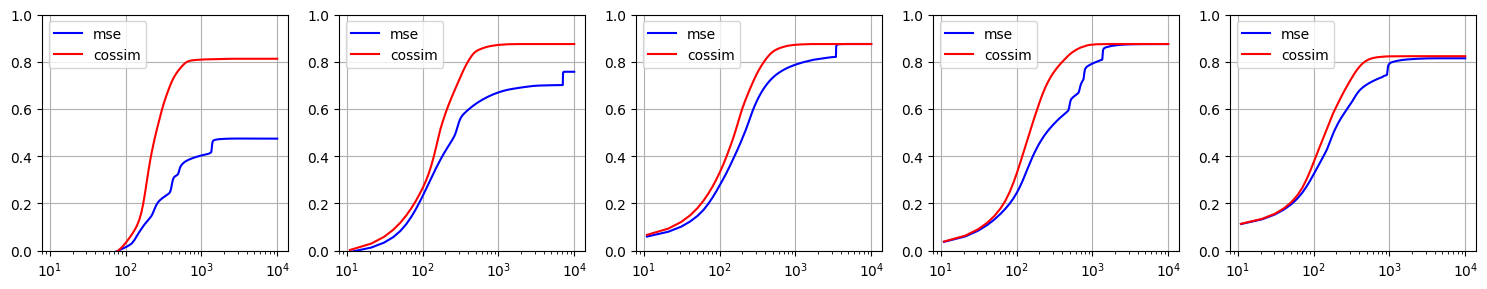

In [13]:
plt.figure(figsize=(15, 3))
for i in range(5):
    plt.subplot(1, 5, 1 + i)
    plt.plot(
        np.array(logs['mse'][i]['step']) + 1, 
        logs['mse'][i]['mcc_test'], 
        '-', color='blue', label='mse'
    )
    plt.plot(
        np.array(logs['cossim'][i]['step']) + 1, 
        logs['cossim'][i]['mcc_test'], 
        '-', color='red', label='cossim'
    )
    plt.legend()  
    plt.grid()
    plt.semilogx()
    plt.ylim(0, 1)
plt.tight_layout()
plt.show()

# MLP

In [14]:
H = N * 2

 11%|█         | 1101/10000 [00:01<00:13, 667.27it/s]

[('step', 1000), ('mcc_train', np.float64(0.8834433147967216)), ('loss_train', 0.029559217393398285), ('mcc_test', np.float64(0.8673191923618631)), ('loss_test', 0.03623605892062187)]


 21%|██        | 2081/10000 [00:03<00:11, 679.62it/s]

[('step', 2000), ('mcc_train', np.float64(0.8981829479492335)), ('loss_train', 0.02475040964782238), ('mcc_test', np.float64(0.8769545974964901)), ('loss_test', 0.032942574471235275)]


 31%|███▏      | 3141/10000 [00:04<00:09, 692.04it/s]

[('step', 3000), ('mcc_train', np.float64(0.9057588066602866)), ('loss_train', 0.022356607019901276), ('mcc_test', np.float64(0.8777874702953364)), ('loss_test', 0.03288334980607033)]


 41%|████      | 4081/10000 [00:06<00:08, 692.20it/s]

[('step', 4000), ('mcc_train', np.float64(0.9088915644563368)), ('loss_train', 0.021306056529283524), ('mcc_test', np.float64(0.8769958726795573)), ('loss_test', 0.03319668769836426)]


 51%|█████     | 5088/10000 [00:07<00:06, 715.02it/s]

[('step', 5000), ('mcc_train', np.float64(0.9101620424896113)), ('loss_train', 0.020887181162834167), ('mcc_test', np.float64(0.8761684478788703)), ('loss_test', 0.03352638706564903)]


 61%|██████    | 6116/10000 [00:08<00:05, 710.08it/s]

[('step', 6000), ('mcc_train', np.float64(0.9114868847265053)), ('loss_train', 0.020439080893993378), ('mcc_test', np.float64(0.8752447429332828)), ('loss_test', 0.034048303961753845)]


 71%|███████   | 7124/10000 [00:10<00:04, 699.62it/s]

[('step', 7000), ('mcc_train', np.float64(0.9123011542930224)), ('loss_train', 0.020157422870397568), ('mcc_test', np.float64(0.8745487288239806)), ('loss_test', 0.0344371534883976)]


 81%|████████▏ | 8139/10000 [00:11<00:02, 711.75it/s]

[('step', 8000), ('mcc_train', np.float64(0.9135708872390582)), ('loss_train', 0.019731158390641212), ('mcc_test', np.float64(0.8739702703567258)), ('loss_test', 0.03469220921397209)]


 91%|█████████ | 9075/10000 [00:13<00:01, 676.22it/s]

[('step', 9000), ('mcc_train', np.float64(0.913657834521743)), ('loss_train', 0.01969783753156662), ('mcc_test', np.float64(0.8735666341948517)), ('loss_test', 0.034864407032728195)]


100%|██████████| 10000/10000 [00:14<00:00, 685.98it/s]


[('step', 9990), ('mcc_train', np.float64(0.9137239166371727)), ('loss_train', 0.019675005227327347), ('mcc_test', np.float64(0.8733687187721346)), ('loss_test', 0.03494241088628769)]
mse


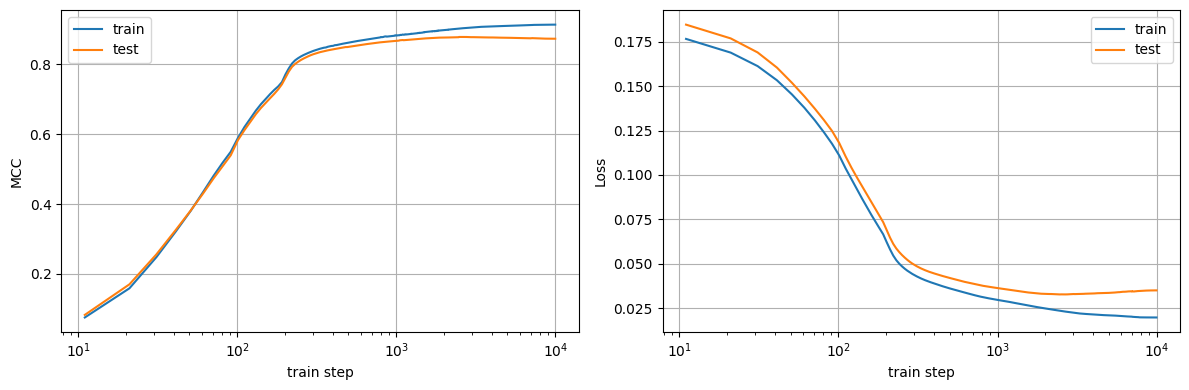

 11%|█         | 1121/10000 [00:01<00:13, 656.74it/s]

[('step', 1000), ('mcc_train', np.float64(0.8961487279367546)), ('loss_train', -0.9008904099464417), ('mcc_test', np.float64(0.8661139420924552)), ('loss_test', -0.8741850852966309)]


 21%|██        | 2101/10000 [00:03<00:12, 631.45it/s]

[('step', 2000), ('mcc_train', np.float64(0.9039497158975833)), ('loss_train', -0.908357560634613), ('mcc_test', np.float64(0.8698240312544212)), ('loss_test', -0.8780553340911865)]


 31%|███       | 3121/10000 [00:04<00:10, 633.08it/s]

[('step', 3000), ('mcc_train', np.float64(0.908594379858308)), ('loss_train', -0.9118319749832153), ('mcc_test', np.float64(0.8694965641740688)), ('loss_test', -0.8771014213562012)]


 41%|████▏     | 4131/10000 [00:06<00:09, 639.77it/s]

[('step', 4000), ('mcc_train', np.float64(0.9116087944776099)), ('loss_train', -0.9145523309707642), ('mcc_test', np.float64(0.8720788158585739)), ('loss_test', -0.8794967532157898)]


 51%|█████     | 5081/10000 [00:08<00:07, 629.22it/s]

[('step', 5000), ('mcc_train', np.float64(0.9125725698724076)), ('loss_train', -0.9154135584831238), ('mcc_test', np.float64(0.8710891620167366)), ('loss_test', -0.8786085844039917)]


 61%|██████    | 6111/10000 [00:09<00:06, 639.43it/s]

[('step', 6000), ('mcc_train', np.float64(0.9126352314843931)), ('loss_train', -0.9154670238494873), ('mcc_test', np.float64(0.8710488527704319)), ('loss_test', -0.8785848617553711)]


 71%|███████   | 7081/10000 [00:11<00:04, 645.31it/s]

[('step', 7000), ('mcc_train', np.float64(0.9126444323740616)), ('loss_train', -0.9154782891273499), ('mcc_test', np.float64(0.8709741967357492)), ('loss_test', -0.8785203099250793)]


 81%|████████  | 8121/10000 [00:12<00:02, 646.75it/s]

[('step', 8000), ('mcc_train', np.float64(0.912637524279244)), ('loss_train', -0.9154782891273499), ('mcc_test', np.float64(0.870948375349681)), ('loss_test', -0.8784855008125305)]


 91%|█████████ | 9091/10000 [00:14<00:01, 648.05it/s]

[('step', 9000), ('mcc_train', np.float64(0.9126474671440813)), ('loss_train', -0.9154840707778931), ('mcc_test', np.float64(0.8709926871332434)), ('loss_test', -0.8785324096679688)]


100%|██████████| 10000/10000 [00:15<00:00, 638.08it/s]


[('step', 9990), ('mcc_train', np.float64(0.9126545007565432)), ('loss_train', -0.9154853820800781), ('mcc_test', np.float64(0.8709678347087481)), ('loss_test', -0.8785117864608765)]
cossim


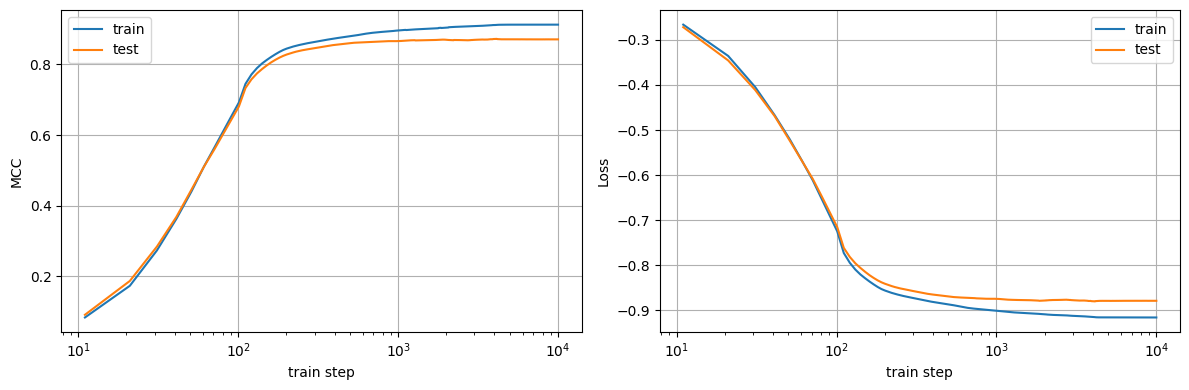

In [15]:
for obj in ['mse', 'cossim']:
    torch.manual_seed(seed)
    MLP = nn.Sequential(nn.Linear(M, H), nn.ReLU(), nn.Linear(H, N), nn.ReLU()).to(device)
    log = train(model=MLP, verbose=2, objective=obj)
    print(obj)
    plot(log)

In [16]:
num_rep = 5
logs_mlp = {'cossim': []}
for rep in range(num_rep):
    for obj in ['cossim']:
        print(rep, obj)
        torch.manual_seed(seed + rep)
        MLP = nn.Sequential(nn.Linear(M, H), nn.ReLU(), nn.Linear(H, N), nn.ReLU()).to(device)
        logs_mlp[obj].append(train(model=MLP, verbose=1, objective=obj))

0 cossim


100%|██████████| 10000/10000 [00:15<00:00, 636.66it/s]


[('step', 9990), ('mcc_train', np.float64(0.9126545007565432)), ('loss_train', -0.9154853820800781), ('mcc_test', np.float64(0.8709678347087481)), ('loss_test', -0.8785117864608765)]
1 cossim


100%|██████████| 10000/10000 [00:16<00:00, 612.19it/s]


[('step', 9990), ('mcc_train', np.float64(0.9754520314550175)), ('loss_train', -0.9783029556274414), ('mcc_test', np.float64(0.9369512621927509)), ('loss_test', -0.9441801309585571)]
2 cossim


100%|██████████| 10000/10000 [00:16<00:00, 609.96it/s]


[('step', 9990), ('mcc_train', np.float64(0.975133183925722)), ('loss_train', -0.9779917001724243), ('mcc_test', np.float64(0.9408358541787141)), ('loss_test', -0.9475830793380737)]
3 cossim


100%|██████████| 10000/10000 [00:15<00:00, 652.02it/s]


[('step', 9990), ('mcc_train', np.float64(0.8551222035356213)), ('loss_train', -0.8580865859985352), ('mcc_test', np.float64(0.8217455237257763)), ('loss_test', -0.8284556865692139)]
4 cossim


100%|██████████| 10000/10000 [00:16<00:00, 615.14it/s]

[('step', 9990), ('mcc_train', np.float64(0.9748263942789126)), ('loss_train', -0.9777531623840332), ('mcc_test', np.float64(0.933176048202681)), ('loss_test', -0.940796971321106)]


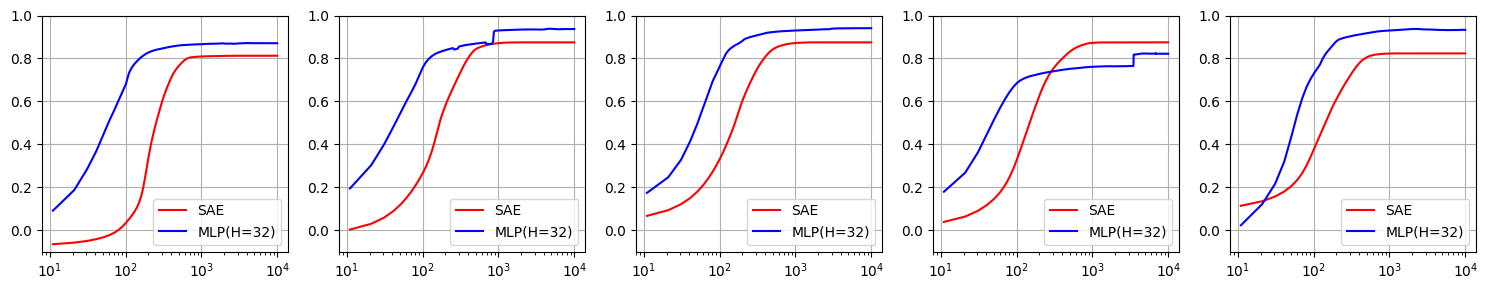

In [17]:
plt.figure(figsize=(15, 3))
for i in range(5):
    plt.subplot(1, 5, 1 + i)
    plt.plot(
        np.array(logs['cossim'][i]['step']) + 1, 
        logs['cossim'][i]['mcc_test'], 
        '-', color='red', label='SAE'
    )
    plt.plot(
        np.array(logs_mlp['cossim'][i]['step']) + 1, 
        logs_mlp['cossim'][i]['mcc_test'], 
        '-', color='blue', label='MLP(H=%s)' % H
    )
    plt.legend()  
    plt.grid()
    plt.semilogx()
    plt.ylim(-.1, 1)
plt.tight_layout()
plt.show()

In [31]:
H2 = 1024
H, H2

(32, 1024)

 11%|█         | 1064/10000 [00:02<00:21, 416.61it/s]

[('step', 1000), ('mcc_train', 0.9891926367046642), ('loss_train', -0.9903150796890259), ('mcc_test', 0.9354611950809864), ('loss_test', -0.9420785307884216)]


 20%|██        | 2047/10000 [00:04<00:19, 416.88it/s]

[('step', 2000), ('mcc_train', 0.9904887916686238), ('loss_train', -0.9914770126342773), ('mcc_test', 0.9367048831699836), ('loss_test', -0.9432796835899353)]


 31%|███       | 3072/10000 [00:07<00:16, 414.99it/s]

[('step', 3000), ('mcc_train', 0.9909923706180814), ('loss_train', -0.9919522404670715), ('mcc_test', 0.9402367900642279), ('loss_test', -0.9464085102081299)]


 41%|████      | 4058/10000 [00:09<00:14, 416.47it/s]

[('step', 4000), ('mcc_train', 0.9909668284557593), ('loss_train', -0.9919013977050781), ('mcc_test', 0.9422876720444333), ('loss_test', -0.948336660861969)]


 51%|█████     | 5089/10000 [00:12<00:09, 501.86it/s]

[('step', 5000), ('mcc_train', 0.991398228783376), ('loss_train', -0.9922887086868286), ('mcc_test', 0.9422921236054711), ('loss_test', -0.9483504891395569)]


 61%|██████    | 6112/10000 [00:14<00:07, 552.05it/s]

[('step', 6000), ('mcc_train', 0.991381513124376), ('loss_train', -0.9922822713851929), ('mcc_test', 0.9427508114828915), ('loss_test', -0.9487005472183228)]


 71%|███████   | 7068/10000 [00:15<00:05, 555.82it/s]

[('step', 7000), ('mcc_train', 0.9915364066055558), ('loss_train', -0.9924232363700867), ('mcc_test', 0.9442010902343293), ('loss_test', -0.9501034021377563)]


 81%|████████  | 8097/10000 [00:17<00:03, 566.95it/s]

[('step', 8000), ('mcc_train', 0.9917920700931131), ('loss_train', -0.9926596879959106), ('mcc_test', 0.9444604551917284), ('loss_test', -0.9503356218338013)]


 91%|█████████ | 9064/10000 [00:19<00:01, 583.85it/s]

[('step', 9000), ('mcc_train', 0.9918329567399549), ('loss_train', -0.9926977157592773), ('mcc_test', 0.9452783187810023), ('loss_test', -0.9510825872421265)]


100%|██████████| 10000/10000 [00:20<00:00, 477.92it/s]


[('step', 9990), ('mcc_train', 0.9919597910055411), ('loss_train', -0.9928168654441833), ('mcc_test', 0.9460938875325363), ('loss_test', -0.9518253207206726)]
cossim


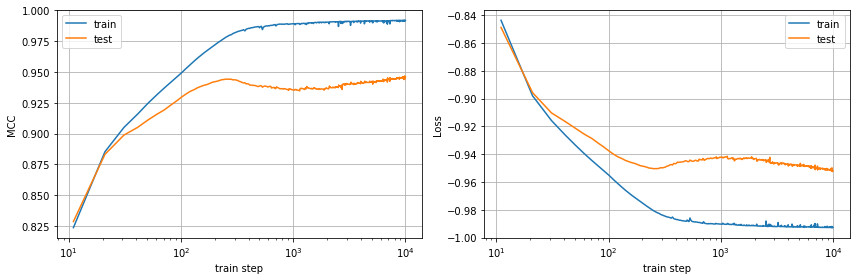

In [32]:
for obj in ['cossim']:
    torch.manual_seed(seed)
    MLP2 = nn.Sequential(nn.Linear(M, H2), nn.ReLU(), nn.Linear(H2, N), nn.ReLU()).to(device)
    log = train(model=MLP2, verbose=2, objective=obj)
    print(obj)
    plot(log)

100%|██████████| 1000/1000 [00:05<00:00, 169.74it/s]


[('step', 999), ('mcc_train', 0.9891900507083586), ('loss_train', -0.9903191328048706), ('mcc_test', 0.9354656067212295), ('loss_test', -0.9420853853225708)]
cossim


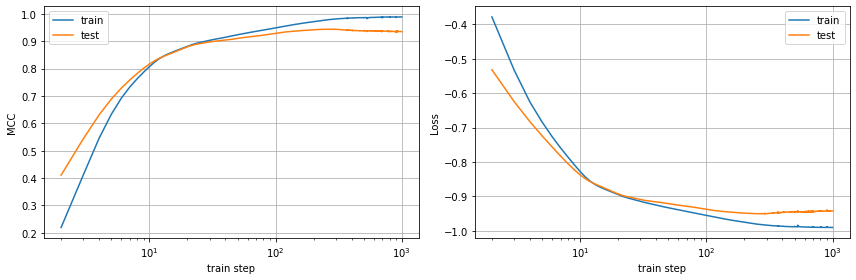

In [35]:
for obj in ['cossim']:
    torch.manual_seed(seed)
    MLP2 = nn.Sequential(nn.Linear(M, H2), nn.ReLU(), nn.Linear(H2, N), nn.ReLU()).to(device)
    log = train(model=MLP2, verbose=2, objective=obj, log_step=1, num_step=1000)
    print(obj)
    plot(log)

 11%|█         | 1103/10000 [00:02<00:16, 542.56it/s]

[('step', 1000), ('mcc_train', 0.9848777422606894), ('loss_train', -0.986478865146637), ('mcc_test', 0.9473028171076656), ('loss_test', -0.9529818296432495)]


 21%|██        | 2103/10000 [00:03<00:14, 543.43it/s]

[('step', 2000), ('mcc_train', 0.9795768824151457), ('loss_train', -0.9812177419662476), ('mcc_test', 0.9417902789083801), ('loss_test', -0.9473474025726318)]


 31%|███       | 3101/10000 [00:05<00:12, 541.06it/s]

[('step', 3000), ('mcc_train', 0.9936271096417056), ('loss_train', -0.9943697452545166), ('mcc_test', 0.9558098328202074), ('loss_test', -0.9607558250427246)]


 41%|████      | 4101/10000 [00:07<00:10, 541.65it/s]

[('step', 4000), ('mcc_train', 0.9959058827519769), ('loss_train', -0.9963635802268982), ('mcc_test', 0.9580131621240402), ('loss_test', -0.9627277851104736)]


 51%|█████     | 5099/10000 [00:09<00:09, 543.90it/s]

[('step', 5000), ('mcc_train', 0.9967996126454235), ('loss_train', -0.9971510171890259), ('mcc_test', 0.9593381156127527), ('loss_test', -0.9639372825622559)]


 61%|██████    | 6098/10000 [00:11<00:07, 544.61it/s]

[('step', 6000), ('mcc_train', 0.9968626184990622), ('loss_train', -0.9972026348114014), ('mcc_test', 0.9600805677545956), ('loss_test', -0.9645764827728271)]


 71%|███████   | 7098/10000 [00:13<00:05, 544.67it/s]

[('step', 7000), ('mcc_train', 0.9965952668777229), ('loss_train', -0.996969997882843), ('mcc_test', 0.9601680794414166), ('loss_test', -0.9646490216255188)]


 81%|████████  | 8091/10000 [00:14<00:03, 537.72it/s]

[('step', 8000), ('mcc_train', 0.9968058523419989), ('loss_train', -0.9971523284912109), ('mcc_test', 0.9605343935666886), ('loss_test', -0.9649186730384827)]


 91%|█████████ | 9090/10000 [00:16<00:01, 543.11it/s]

[('step', 9000), ('mcc_train', 0.9970411942450965), ('loss_train', -0.9973559975624084), ('mcc_test', 0.9606559286096614), ('loss_test', -0.9651230573654175)]


100%|██████████| 10000/10000 [00:18<00:00, 541.97it/s]


[('step', 9990), ('mcc_train', 0.9914332483019355), ('loss_train', -0.9923536777496338), ('mcc_test', 0.961342230012147), ('loss_test', -0.9656393527984619)]
cossim


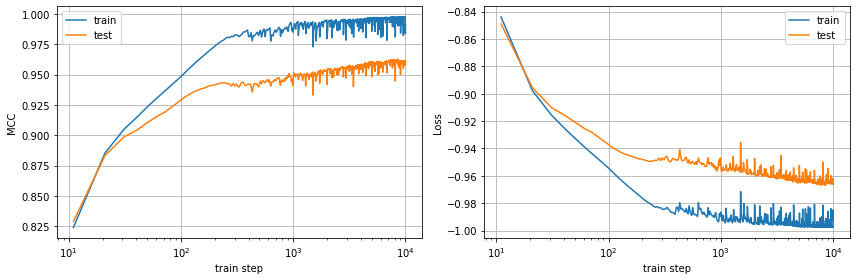

In [37]:
for obj in ['cossim']:
    torch.manual_seed(seed)
    MLP2 = nn.Sequential(nn.Linear(M, H2), nn.ReLU(), nn.Linear(H2, N), nn.ReLU()).to(device)
    log = train(model=MLP2, verbose=2, objective=obj, wd=1e-3)
    print(obj)
    plot(log)

 11%|█         | 1084/10000 [00:02<00:16, 533.09it/s]

[('step', 1000), ('mcc_train', 0.978768698093954), ('loss_train', -0.9800676107406616), ('mcc_test', 0.9529544859990897), ('loss_test', -0.9577767848968506)]


 21%|██        | 2072/10000 [00:03<00:14, 532.08it/s]

[('step', 2000), ('mcc_train', 0.9867944306728392), ('loss_train', -0.9879518747329712), ('mcc_test', 0.9520412221301213), ('loss_test', -0.9566206932067871)]


 31%|███       | 3056/10000 [00:05<00:12, 537.38it/s]

[('step', 3000), ('mcc_train', 0.98779257480071), ('loss_train', -0.9889282584190369), ('mcc_test', 0.9560856500957552), ('loss_test', -0.9603983163833618)]


 41%|████      | 4100/10000 [00:07<00:10, 537.04it/s]

[('step', 4000), ('mcc_train', 0.9726564471400406), ('loss_train', -0.9752271175384521), ('mcc_test', 0.949721544712715), ('loss_test', -0.9547080993652344)]


 51%|█████     | 5084/10000 [00:09<00:09, 533.86it/s]

[('step', 5000), ('mcc_train', 0.9842970144808548), ('loss_train', -0.9856150150299072), ('mcc_test', 0.9587340105182406), ('loss_test', -0.9633315205574036)]


 61%|██████    | 6071/10000 [00:11<00:07, 534.29it/s]

[('step', 6000), ('mcc_train', 0.984944275675898), ('loss_train', -0.9866265058517456), ('mcc_test', 0.9562494197310134), ('loss_test', -0.961020290851593)]


 71%|███████   | 7061/10000 [00:13<00:05, 534.29it/s]

[('step', 7000), ('mcc_train', 0.9895329587682842), ('loss_train', -0.9900959730148315), ('mcc_test', 0.9585884827945124), ('loss_test', -0.9630966186523438)]


 81%|████████  | 8106/10000 [00:15<00:03, 539.00it/s]

[('step', 8000), ('mcc_train', 0.9891893528386103), ('loss_train', -0.990225076675415), ('mcc_test', 0.9600407732492428), ('loss_test', -0.9644198417663574)]


 91%|█████████ | 9090/10000 [00:16<00:01, 535.60it/s]

[('step', 9000), ('mcc_train', 0.9907200524883488), ('loss_train', -0.9917619228363037), ('mcc_test', 0.9597757318974456), ('loss_test', -0.9644153118133545)]


100%|██████████| 10000/10000 [00:18<00:00, 535.84it/s]


[('step', 9990), ('mcc_train', 0.9908656707904399), ('loss_train', -0.9918426275253296), ('mcc_test', 0.9590544758894242), ('loss_test', -0.9637092351913452)]
cossim


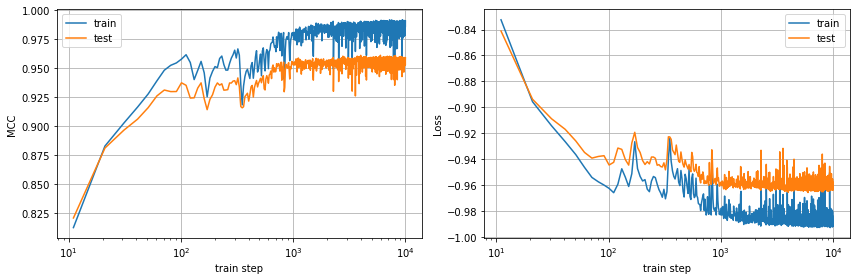

In [39]:
for obj in ['cossim']:
    torch.manual_seed(seed)
    MLP2 = nn.Sequential(nn.Linear(M, H2), nn.ReLU(), nn.Linear(H2, N), nn.ReLU()).to(device)
    log = train(model=MLP2, verbose=2, objective=obj, wd=1e-1)
    print(obj)
    plot(log)

 11%|█         | 1088/10000 [00:02<00:19, 464.25it/s]

[('step', 1000), ('mcc_train', 0.9128975896236047), ('loss_train', -0.9231833219528198), ('mcc_test', 0.8950182928962195), ('loss_test', -0.9070712924003601)]


 21%|██        | 2090/10000 [00:04<00:16, 470.72it/s]

[('step', 2000), ('mcc_train', 0.9233384431381825), ('loss_train', -0.9323078393936157), ('mcc_test', 0.9004585220902226), ('loss_test', -0.9117979407310486)]


 31%|███       | 3083/10000 [00:06<00:14, 462.77it/s]

[('step', 3000), ('mcc_train', 0.925803824384153), ('loss_train', -0.9344615936279297), ('mcc_test', 0.9083145624995315), ('loss_test', -0.9186826944351196)]


 41%|████      | 4076/10000 [00:08<00:12, 463.42it/s]

[('step', 4000), ('mcc_train', 0.9298771222532689), ('loss_train', -0.9382268190383911), ('mcc_test', 0.9115667878072025), ('loss_test', -0.9214768409729004)]


 51%|█████     | 5081/10000 [00:10<00:10, 457.09it/s]

[('step', 5000), ('mcc_train', 0.9316488363017765), ('loss_train', -0.9396445751190186), ('mcc_test', 0.908981948116925), ('loss_test', -0.9191734790802002)]


 61%|██████    | 6082/10000 [00:13<00:08, 460.09it/s]

[('step', 6000), ('mcc_train', 0.9331914377550816), ('loss_train', -0.9409281015396118), ('mcc_test', 0.9086398458009427), ('loss_test', -0.9188439846038818)]


 71%|███████   | 7088/10000 [00:15<00:06, 467.06it/s]

[('step', 7000), ('mcc_train', 0.9287396197290834), ('loss_train', -0.9370070695877075), ('mcc_test', 0.9106754712782456), ('loss_test', -0.9206856489181519)]


 81%|████████  | 8051/10000 [00:17<00:04, 461.86it/s]

[('step', 8000), ('mcc_train', 0.9330454803013627), ('loss_train', -0.9408936500549316), ('mcc_test', 0.9101249253611692), ('loss_test', -0.9201978445053101)]


 91%|█████████ | 9067/10000 [00:19<00:02, 464.84it/s]

[('step', 9000), ('mcc_train', 0.9341855078070146), ('loss_train', -0.9418853521347046), ('mcc_test', 0.9094841810569875), ('loss_test', -0.9196343421936035)]


100%|██████████| 10000/10000 [00:21<00:00, 463.30it/s]


[('step', 9990), ('mcc_train', 0.9364538575966054), ('loss_train', -0.9439336657524109), ('mcc_test', 0.9113982058316843), ('loss_test', -0.9211748838424683)]
cossim


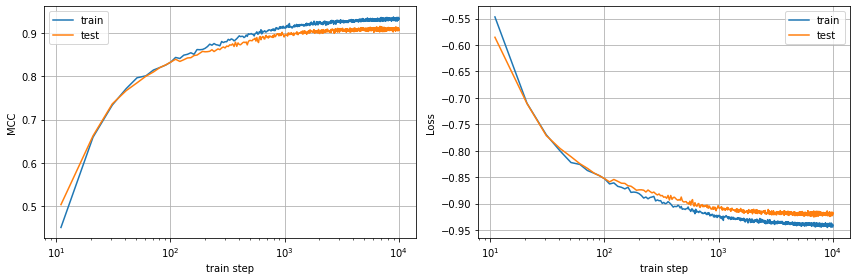

In [41]:
for obj in ['cossim']:
    torch.manual_seed(seed)
    MLP2 = nn.Sequential(nn.Linear(M, H2), nn.ReLU(), nn.Dropout(0.9), nn.Linear(H2, N), nn.ReLU()).to(device)
    log = train(model=MLP2, verbose=2, objective=obj, wd=0)
    print(obj)
    plot(log)

In [33]:
num_rep = 5
logs_mlp2 = {'cossim': []}
for rep in range(num_rep):
    for obj in ['cossim']:
        print(rep, obj)
        torch.manual_seed(seed + rep)
        MLP = nn.Sequential(nn.Linear(M, H2), nn.ReLU(), nn.Linear(H2, N), nn.ReLU()).to(device)
        logs_mlp2[obj].append(train(model=MLP, verbose=1, objective=obj))

0 cossim


100%|██████████| 10000/10000 [00:18<00:00, 551.23it/s]


[('step', 9990), ('mcc_train', 0.9919597910055411), ('loss_train', -0.9928168654441833), ('mcc_test', 0.9460938875325363), ('loss_test', -0.9518253207206726)]
1 cossim


100%|██████████| 10000/10000 [00:17<00:00, 559.24it/s]


[('step', 9990), ('mcc_train', 0.9906127130794744), ('loss_train', -0.9916141033172607), ('mcc_test', 0.9468061801097325), ('loss_test', -0.9524368047714233)]
2 cossim


100%|██████████| 10000/10000 [00:17<00:00, 557.24it/s]


[('step', 9990), ('mcc_train', 0.9898883977864261), ('loss_train', -0.9909584522247314), ('mcc_test', 0.946434485405078), ('loss_test', -0.95207679271698)]
3 cossim


100%|██████████| 10000/10000 [00:17<00:00, 557.31it/s]


[('step', 9990), ('mcc_train', 0.9912222252944265), ('loss_train', -0.9921603798866272), ('mcc_test', 0.9474587003808153), ('loss_test', -0.9530916213989258)]
4 cossim


100%|██████████| 10000/10000 [00:17<00:00, 559.83it/s]

[('step', 9990), ('mcc_train', 0.9913005280764309), ('loss_train', -0.9922243356704712), ('mcc_test', 0.9479472745096303), ('loss_test', -0.9534988403320312)]


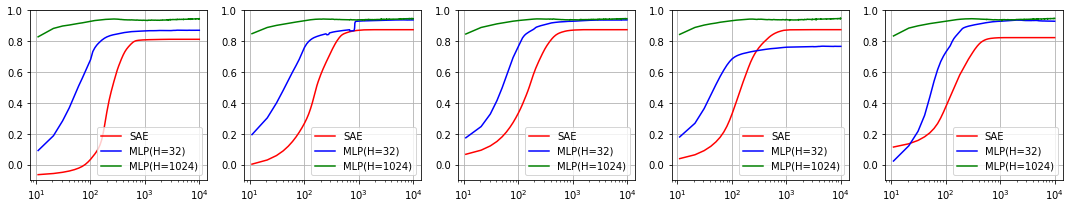

In [34]:
plt.figure(figsize=(15, 3))
for i in range(5):
    plt.subplot(1, 5, 1 + i)
    plt.plot(
        np.array(logs['cossim'][i]['step']) + 1, 
        logs['cossim'][i]['mcc_test'], 
        '-', color='red', label='SAE'
    )
    plt.plot(
        np.array(logs_mlp['cossim'][i]['step']) + 1, 
        logs_mlp['cossim'][i]['mcc_test'], 
        '-', color='blue', label='MLP(H=%s)' % H
    )
    plt.plot(
        np.array(logs_mlp2['cossim'][i]['step']) + 1, 
        logs_mlp2['cossim'][i]['mcc_test'], 
        '-', color='green', label='MLP(H=%s)' % H2
    )
    plt.legend()  
    plt.grid()
    plt.semilogx()
    plt.ylim(-.1, 1)
plt.tight_layout()
plt.show()